In [8]:
import sys
import math
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model


models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [2]:
@torch.no_grad()
def compute_renyi_entropy(samples: torch.Tensor, subs_size: int, log_score_fn: callable) -> tuple[float, float]:
    n_samples = samples.shape[0]
    half = n_samples // 2

    if half == 0:
        return float("nan"), 0.0

    # split up samples into two replicas and score them
    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]
    ref_score_1 = log_score_fn(ref_1)
    ref_score_2 = log_score_fn(ref_2)

    # find indices for slicing
    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    # recombine into swapped samples and score them
    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]
    swap_score_1 = log_score_fn(swap_1)
    swap_score_2 = log_score_fn(swap_2)

    # calculate swap ratio in log-space
    log_ratios = (swap_score_1 + swap_score_2) - (ref_score_1 + ref_score_2)

    N = log_ratios.numel()

    # renyi entropy as log over mean
    log_mean_r = torch.logsumexp(log_ratios, dim=0) - math.log(N)
    renyi_entropy = -log_mean_r.item()

    # we need mean(R) and mean(R^2) for error estimation
    mean_r = torch.exp(log_mean_r).item()
    log_mean_sq_r = torch.logsumexp(2 * log_ratios, dim=0) - math.log(N)
    mean_sq_r = torch.exp(log_mean_sq_r).item()

    # error via delta method: SE = StdDev(R) / (Mean(R) * sqrt(N))
    var_r = max(0.0, mean_sq_r - mean_r**2) # clamp for numerical noise (negatives)
    se_r = math.sqrt(var_r / N)
    entropy_err = se_r / mean_r if mean_r > 0 else float("inf")

    return renyi_entropy, entropy_err

In [3]:
model_filename = "hyprbm_tfim_16_20000_20260204_034149.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

CHAIN_LENGTH = int(model.num_v)
h_support_vals = sorted(config.get("h_support", []))
print(f"Trained on support points: {h_support_vals} \n")

ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}")

Loading checkpoint: hyprbm_tfim_16_20000_20260204_034149.pt
Trained on support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5] 

Loaded ED reference data from: tfim_16_entangle_ref.csv


In [18]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

K_STEPS = 20
TOTAL_SAMPLES = 100_000
DENSE_RES = 0.05

h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

print(f"Sweeping h: [{min(all_h_values):.2f}, {max(all_h_values):.2f}]")

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))

rng_eval = torch.Generator(device=device).manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

for h_val in all_h_values:
    split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "novel"
    print(f"h={h_val:.2f} ({split:12})", end=" ... ")

    # extend h_val to batch defining number of samples / define constant temperature schedule for k_steps
    cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)
    schedule = torch.tensor([1.0] * K_STEPS, device=device, dtype=model_dtype)

    with torch.no_grad():
        samples = model.generate(cond_batch, schedule, rng=rng_eval)

    # define a scorer closure
    def scorer(v):
        c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
        return model.log_score(v, c)

    # compute entropy for all l values
    for l in l_axis:
        s2, s2_err = compute_renyi_entropy(samples, l, scorer)

        results_list.append({"h": float(h_val), "l": int(l), "type": split, "s2": s2, "s2_err": s2_err})

    del samples
    print("Done")

results_df = pd.DataFrame(results_list)

Sweeping h: [0.50, 1.50]
h=0.50 (support     ) ... Done
h=0.55 (novel       ) ... Done
h=0.60 (novel       ) ... Done
h=0.65 (novel       ) ... Done
h=0.70 (novel       ) ... Done
h=0.75 (novel       ) ... Done
h=0.80 (support     ) ... Done
h=0.85 (novel       ) ... Done
h=0.90 (novel       ) ... Done
h=0.95 (support     ) ... Done
h=1.00 (support     ) ... Done
h=1.05 (support     ) ... Done
h=1.10 (novel       ) ... Done
h=1.15 (novel       ) ... Done
h=1.20 (support     ) ... Done
h=1.25 (novel       ) ... Done
h=1.30 (novel       ) ... Done
h=1.35 (novel       ) ... Done
h=1.40 (novel       ) ... Done
h=1.45 (novel       ) ... Done
h=1.50 (support     ) ... Done


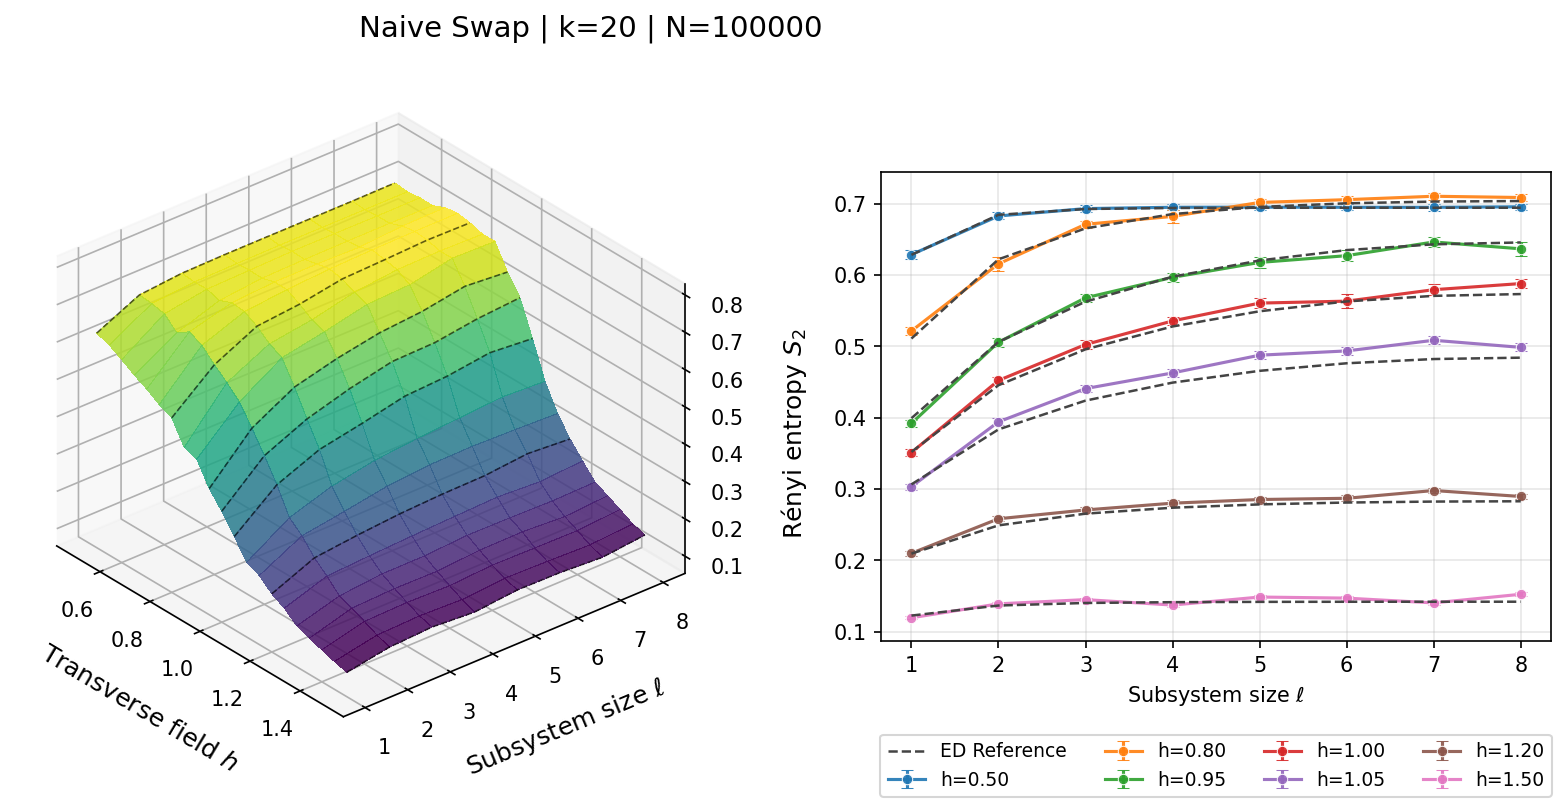

In [19]:
# CONFIGURATION (plot only)
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

MAX_SURF_COLS = 220
MAX_SURF_ROWS = 80
SURF_SHADE    = False

pivot_df = results_df.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense  = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)

support_h_keys = sorted(results_df[results_df['type'] == 'support']['h'].unique())


fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')

fig.suptitle(f"Naive Swap | k={K_STEPS} | N={TOTAL_SAMPLES}", fontsize=14, y=0.95)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# 3D surface plot
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

step_c = max(1, X_h.shape[1] // MAX_SURF_COLS)
step_r = max(1, X_h.shape[0] // MAX_SURF_ROWS)

Xr = X_h[::step_r, ::step_c]
Yr = Y_l[::step_r, ::step_c]
Zr = Z_s2[::step_r, ::step_c]

surf = ax3d.plot_surface(Xr, Yr, Zr, cmap='viridis', rstride=1, cstride=1,
                         shade=SURF_SHADE, linewidth=0, antialiased=False, alpha=0.85)

ax3d.set_zlim(np.nanmin(Zr) - 0.05, np.nanmax(Zr) + 0.1)
ax3d.set_xlabel("Transverse field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel("Rényi entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

# onto the surface plot, add dashed lines for support h values
for h in support_h_keys:
    subset = results_df[results_df['h'] == h].sort_values('l')
    ax3d.plot(np.full_like(l_values, float(h), dtype=float), l_values, subset['s2'].to_numpy(dtype=float),
        color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10)

# 2D plot
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d = plt.get_cmap("tab10")

ref_lbl_added = False

for i, h in enumerate(support_h_keys):
    subset = results_df[results_df['h'] == h].sort_values('l')
    s2 = subset['s2'].to_numpy(dtype=float)
    err = subset['s2_err'].to_numpy(dtype=float)
    col = cmap_2d(i % 10)

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values], key=lambda s: int(s[1:]))
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
            x_ref = [int(c[1:]) for c in l_cols]
            lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, '--', color='#444444', linewidth=1.2, label=lbl, zorder=5)
            ref_lbl_added = True

    # add normal error bars to 2D plot
    ax2d.errorbar(l_values, s2, yerr=err, fmt='o-', color=col, markersize=5, linewidth=1.5, alpha=0.9,
                  markeredgecolor='white', markeredgewidth=0.5, capsize=3, elinewidth=1.5, label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$")
ax2d.legend(frameon=True, fontsize=9, loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)

plt.show()

In [20]:
results_df = results_df.drop(columns=["s2_err"])

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"tfim_{CHAIN_LENGTH}_entangle_rbm_{timestamp}.csv"
save_path = results_dir / filename

results_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Data saved to: {save_path}")
print(f"Rows: {len(results_df)}")

Data saved to: results/tfim_16_entangle_rbm_20260204_184558.csv
Rows: 168
